### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**Let's check for some null values** 

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

**As the fraction of missing values is much lesser compared to the size of the dataset, we can drop the null values**

In [7]:
df.dropna(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


For customer segmentation, we can use a feature engineering method like RFM analysis. Using this method we can convert the columns into
1. Recency - No of days passed since last purchase

2. Frequency - No of purchases

3. Monetary - Amount of money spent

In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
df['Monetary'] = df['Quantity'] * df['UnitPrice']

In [11]:
feat_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
                                            'InvoiceNo': 'count',
                                            'Monetary': 'sum'})

In [12]:
feat_df.head()

,InvoiceDate,InvoiceNo,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


In [13]:
feat_df.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency'},inplace=True)

In [14]:
feat_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


### EDA

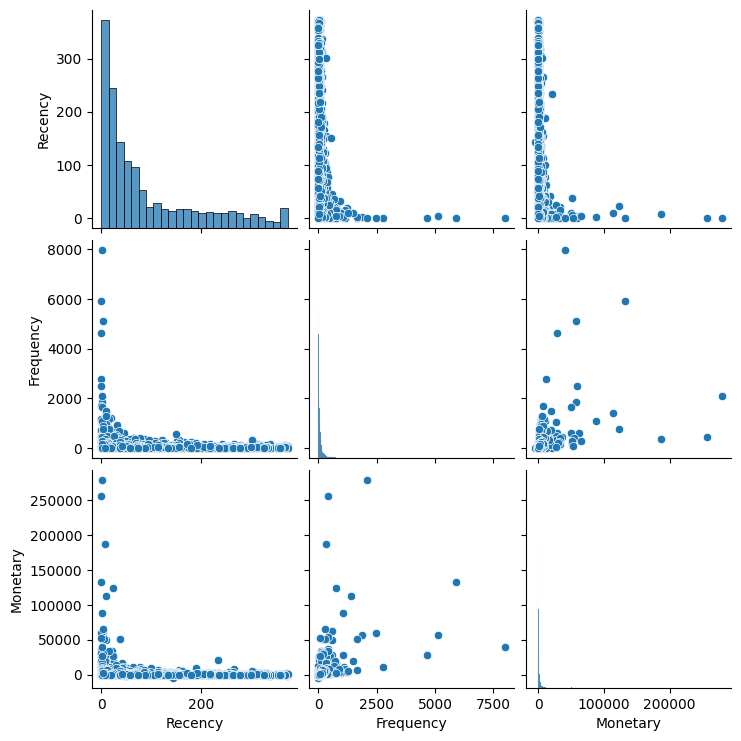

In [15]:
sns.pairplot(feat_df)

### Scaling the data

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [17]:
scaled_df = scaler.fit_transform(feat_df)

### KMeans

In [18]:
from sklearn.cluster import KMeans

In [19]:
clusters = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=33)
    kmeans.fit(scaled_df)
    clusters.append(kmeans.inertia_)

Text(0, 0.5, 'sse')

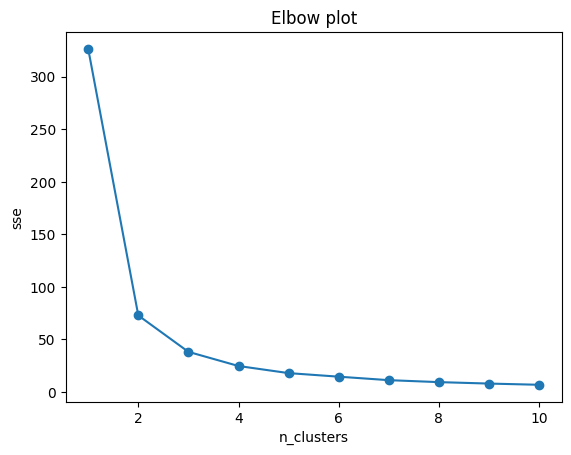

In [20]:
plt.plot(range(1, 11), clusters, marker='o')
plt.title('Elbow plot')
plt.xlabel('n_clusters')
plt.ylabel('sse')

**We can select the n_clusters as 3 as the performance doesn't change much after 3**

In [21]:
kmeans_model = KMeans(n_clusters=3, n_init=10, random_state=33)
kmeans_model.fit(scaled_df)

KMeans(n_clusters=3, n_init=10, random_state=33)

In [22]:
result_df = pd.DataFrame(scaled_df, columns=feat_df.columns, index=feat_df.index)
result_df['cluster'] = kmeans_model.labels_
result_df

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346.0,0.871314,0.000125,0.015109,1
12347.0,0.002681,0.022676,0.030297,2
12348.0,0.198391,0.003758,0.021442,2
12349.0,0.048257,0.009020,0.021303,2
12350.0,0.828418,0.002005,0.016288,1
...,...,...,...,...
18280.0,0.742627,0.001128,0.015746,1
18281.0,0.482574,0.000752,0.015394,0
18282.0,0.018767,0.001503,0.015731,2


In [23]:
cl = kmeans_model.fit_predict(scaled_df)

In [24]:
cl

array([1, 2, 2, ..., 2, 2, 2])

### Evaluation

In [25]:
from sklearn.metrics import silhouette_score

In [26]:
print("Silhouette Score:",silhouette_score(scaled_df,cl))

Silhouette Score: 0.6570112841149758


In [27]:
prediction_sample = [[0.871314,0.022676,0.045297]]
res = kmeans_model.predict(prediction_sample)

In [28]:
print("Predicted Cluster:",res[0])

Predicted Cluster: 1


**We can visualize the predicted clusters as follows**

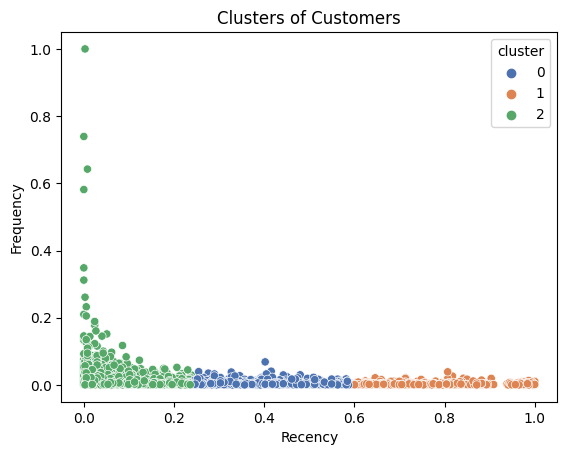

In [29]:
sns.scatterplot(data=result_df, x='Recency', y='Frequency', hue='cluster', palette='deep')
plt.title('Clusters of Customers')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

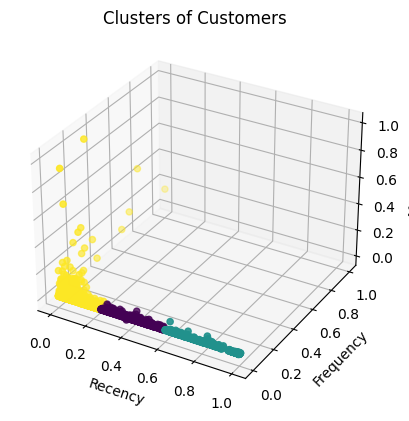

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result_df['Recency'], result_df['Frequency'], result_df['Monetary'], c=result_df['cluster'])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('Clusters of Customers')
plt.show()

<Axes: xlabel='cluster', ylabel='Recency'>

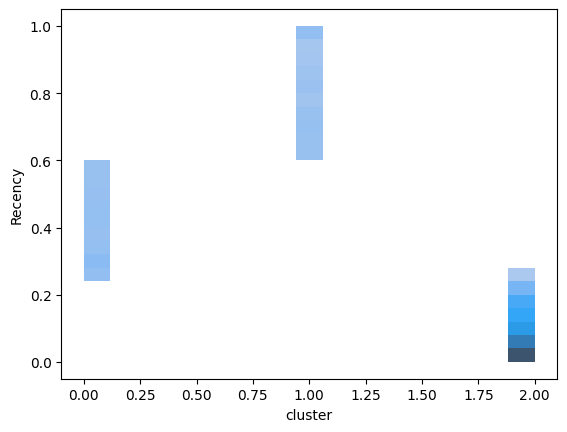

In [31]:
sns.histplot(x='cluster',y='Recency',data=result_df)

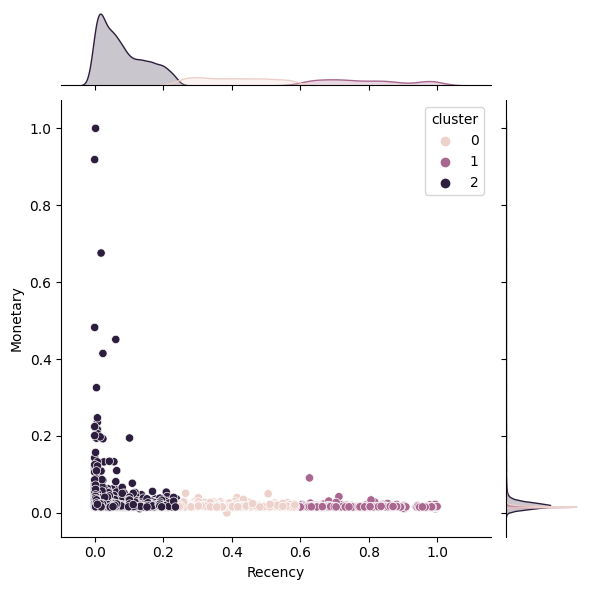

In [32]:
sns.jointplot(x='Recency',y='Monetary',data=result_df,hue='cluster')